In [1]:
import pickle
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.8"

from jax.config import config
#config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import seaborn as sns
from tqdm.notebook import tqdm, trange

from itertools import product
import functools
import awkward as ak
import pandas as pd
from hyperion.constants import Constants
from olympus.event_generation.mc_record import MCRecord
from olympus.event_generation.photon_source import PhotonSource, PhotonSourceType
from olympus.event_generation.photon_propagation.norm_flow_photons import make_generate_norm_flow_photons, make_nflow_photon_likelihood, make_nflow_photon_likelihood_per_module
from olympus.event_generation.photon_propagation.utils import sources_to_model_input_per_module, sources_to_array
from olympus.event_generation.detector import make_hex_grid, Detector, make_line, make_triang, make_rhombus
from olympus.event_generation.event_generation import generate_cascade, generate_muon_energy_losses, generate_realistic_track, simulate_noise
from olympus.event_generation.lightyield import make_pointlike_cascade_source, make_realistic_cascade_source
from olympus.event_generation.utils import proposal_setup
from olympus.plotting.plotting import plot_event
from olympus.optimization.fisher_information import  calc_fisher_info_cascades, pad_event

from hyperion.utils import (
    make_cascadia_abs_len_func,
)
from hyperion.pmt.pmt import make_calc_wl_acceptance_weight
from hyperion.medium import cascadia_ref_index_func, sca_len_func_antares
from hyperion.constants import Constants

from hyperion.models.photon_arrival_time_nflow.net import (
    make_counts_net_fn,
    make_shape_conditioner_fn,
    sample_shape_model,
    traf_dist_builder,
    eval_log_prob
)

import jax
from jax import jit, random
from jax import numpy as jnp
from jax import value_and_grad
from numba.typed import List
from jax.experimental.maps import xmap, SerialLoop

from fennel import Fennel, config

import json
%matplotlib inline
from scipy.integrate import quad

In [2]:
def sph_to_cart_jnp(theta, phi=0):
    """Transform spherical to cartesian coordinates."""
    x = jnp.sin(theta) * jnp.cos(phi)
    y = jnp.sin(theta) * jnp.sin(phi)
    z = jnp.cos(theta)

    return jnp.asarray([x, y, z], dtype=jnp.float64)

ref_index_func = cascadia_ref_index_func
abs_len = make_cascadia_abs_len_func(sca_len_func_antares)

def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)




In [3]:
lh_per_mod = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    
))

lh_per_mod_first = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    mode="tfirst"
    
))

#lh_per_mod_vtime = jax.vmap(lh_per_mod, in_axes=[0, None, None, None, None, None, None, None])

In [4]:
module_coords = jnp.asarray([30., 0, 0.])
source_pos = jnp.asarray([[0, 0, 0]])
source_dir = jnp.asarray([[1., 0, 0]])
source_time = jnp.asarray([0])
source_photons = jnp.asarray([1E9])


c_medium = c_medium_f(700) / 1E9
t_geo = jnp.linalg.norm(source_pos - module_coords) / c_medium

time = jnp.linspace(-20+t_geo, 100+t_geo, 100)


In [5]:
lh_per_mod_first(
        time,
        1,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5)

(DeviceArray([-17.962286], dtype=float32),
 DeviceArray(-625.8377, dtype=float32))

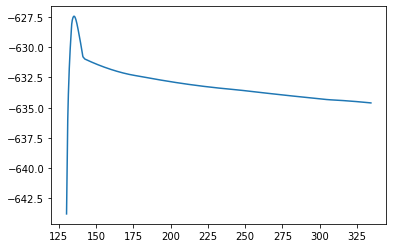

In [7]:
time = jnp.linspace(t_geo-4, 200+t_geo, 1000).reshape(1000, 1)
lhs = jax.vmap(lh_per_mod, in_axes=[0] + [None] * 8)(
        time,
        1,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5)
plt.plot(time, lhs.squeeze())

0.8005849
0.9699342


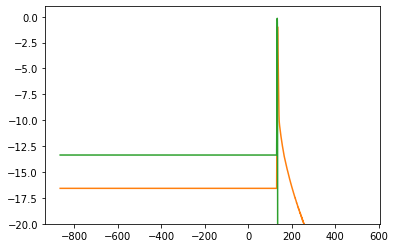

In [11]:
time = jnp.linspace(-1000+t_geo, 100+t_geo, 1000).reshape(1000, 1)

lhs = jax.vmap(lh_per_mod, in_axes=[0] + [None] * 8)(
        time,
        1,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5)
plt.plot(time, lhs.squeeze())


time = jnp.linspace(-1000+t_geo, 400+t_geo, 3000)
tmins = time.reshape(time.shape[0], 1)

lhs = jax.vmap(lh_per_mod_first, in_axes=[0] + [None] * 8)(
        time,
        4,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5)
plt.plot(time, lhs[0].squeeze())
print(jnp.trapz(jnp.exp(lhs[0]).squeeze(), x=time))

lhs = jax.vmap(lh_per_mod_first, in_axes=[0] + [None] * 8)(
        time,
        100,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5)
plt.plot(time, lhs[0].squeeze())

plt.ylim(-20, 1)
print(jnp.trapz(jnp.exp(lhs[0]).squeeze(), x=time))


In [ ]:
lhs.shape

(1000, 1, 1)

In [ ]:
time = jnp.linspace(-1000+t_geo, 4000+t_geo, 5000)
lhs = lh_per_mod(
        time,
        1,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5)
jnp.trapz(jnp.exp(lhs).squeeze(), x=time)

DeviceArray(0.9956629, dtype=float32)

In [8]:
tmins = jnp.linspace(-1000, 4000, 2000).reshape(2000, 1)

lhs = jnp.trapz(jax.vmap(lh_per_mod_first, in_axes=[0] + [None] * 8)(
        time,
        100,
        module_coords,
        source_pos,
        source_dir,
        source_time,
        source_photons,
        c_medium,
        1E-5), x=tmins)

Invalid value encountered in the output of a jit/pmap-ed function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in log

In [123]:
lhs

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1E4 * 1E-9  # 1/ns

gen_ph = make_generate_norm_flow_photons(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    c_medium=c_medium_f(700) * 1E-9
)

lh_per_mod = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
))

tfirst_lh_per_mod = make_nflow_photon_likelihood_per_module(
    "data/photon_tfirst_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    mode="tfirst"
)

evlh = jax.vmap(lh_per_mod, in_axes=[0, 0, 0, None, None, None, None, None, 0])


def eval_for_mod(x, y, z, theta, phi, t, log10e, times, mod_coords, noise_rate, key):

    pos = jnp.asarray([x, y, z])
    dir = sph_to_cart_jnp(theta, phi)

    sources = make_realistic_cascade_source(pos, t, dir, 10**log10e, 11, resolution=0.5, key=key, moliere_rand=True)
    #sources = make_pointlike_cascade_source(pos, t, dir, 10**log10e, 11)

    return lh_per_mod(
        times,
        mod_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9, noise_rate
    )

eval_jacobian = jax.jit(jax.jacobian(eval_for_mod, [0, 1, 2, 3, 4, 5, 6]))



In [8]:
event_data = {"t0": 0., "theta": np.radians(45), "phi": np.radians(0), "pos": np.asarray([0, 0, -25.]), "energy": 1E5, "pid": 11}
event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])
res = make_realistic_cascade_source(event_data["pos"], event_data["t0"], event_dir, event_data["energy"], 11, random.PRNGKey(0), moliere_rand=True)

/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3646: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


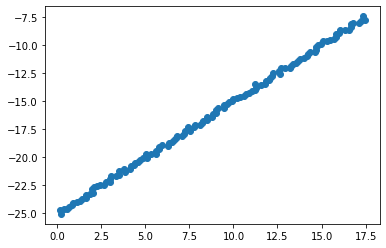

In [5]:
plt.scatter(res[0][:, 0], res[0][:, 2])

In [16]:
det = make_triang(150, 1, dist_z, dark_noise_rate, rng)
event_data = {"time": 0., "theta": np.radians(45), "phi": np.radians(0), "pos": np.asarray([0, 0, -25.]), "energy": 1E5, "particle_id": 11}
event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])
event_data["dir"] = event_dir

event, record = generate_cascade(
    det, event_data, pprop_func=gen_ph,
    seed=random.PRNGKey(1), 
    converter_func=make_realistic_cascade_source,
)
event,_ = simulate_noise(det, event)


In [9]:
eval_for_mod_split_vmap_theta = jax.vmap(
    eval_for_mod_tfirst_split_jit,
    in_axes = [None, None, None, 0, None, None, None,  None,
               None, None, 0]
)

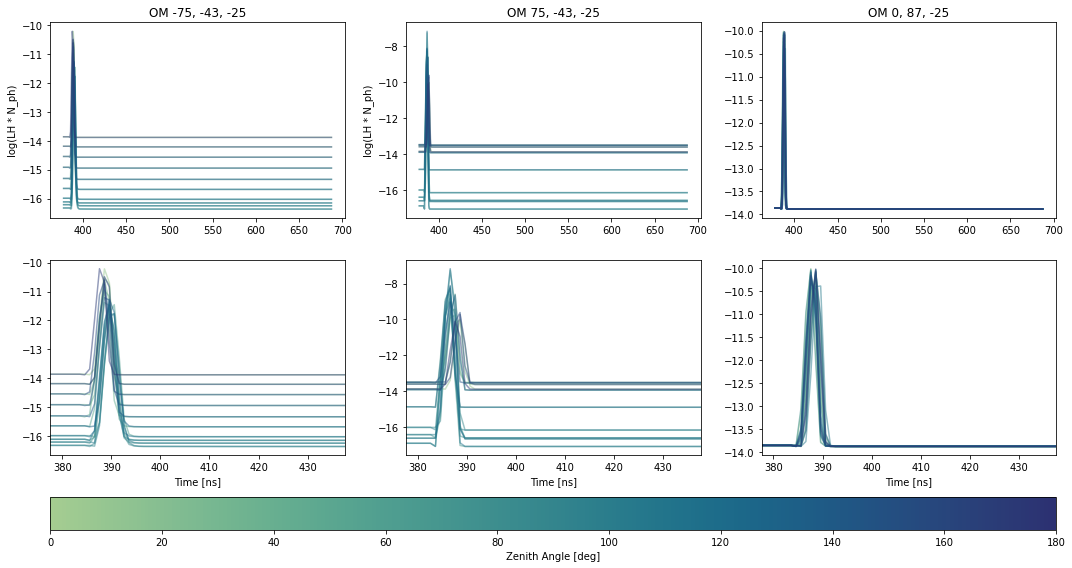

In [11]:
from matplotlib.gridspec import GridSpec
det = make_triang(150, 1, dist_z, dark_noise_rate, rng)
fig = plt.figure(figsize=(15, 4*2))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1/6])


axs = np.asarray([[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)])


key = random.PRNGKey(0)
thetas = np.radians(np.linspace(0, 180, 20))
colors = sns.color_palette("crest", len(thetas))

for i, ax in enumerate(axs.T):
    mod_coords = det.module_coords[i]
    t_geo = np.linalg.norm(event_data["pos"] - mod_coords) / (c_medium_f(700) / 1E9)
    times = jnp.linspace(t_geo-10, t_geo+300, 310)
    
    
    key, subkey = random.split(key)
    keys = random.split(subkey, len(thetas))

    shape_lh, counts_lh, n_pred = eval_for_mod_split_vmap_theta(
        event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], thetas,
        event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
        times, mod_coords, det.module_noise_rates[i], keys
    )

    for color, lh, npr in zip(colors, shape_lh, n_pred):
        ax[0].plot(times, lh + np.log(npr), color=color, alpha=0.5)
        ax[1].plot(times, lh + np.log(npr), color=color, alpha=0.5)
    #ax[0].set_ylim(-10, 5)
    ax[1].set_xlim(t_geo-10, t_geo+50)
    #ax[1].set_ylim(-10, 5)
    ax[0].set_title(f"OM {mod_coords[0]:.0f}, {mod_coords[1]:.0f}, {mod_coords[2]:.0f}")

axs[1][0].set_xlabel("Time [ns]")
axs[1][1].set_xlabel("Time [ns]")
axs[1][2].set_xlabel("Time [ns]")

axs[0][0].set_ylabel("log(LH * N_ph)")
axs[0][1].set_ylabel("log(LH * N_ph)")

cmap = sns.color_palette("crest", len(thetas), as_cmap=True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.degrees(np.min(thetas)), vmax=np.degrees(np.max(thetas))))
cax = fig.add_subplot(gs[2, :], )
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Zenith Angle [deg]")
plt.tight_layout()
#plt.savefig("figures/cascade_likelihood_demo.png", dpi=180)

In [12]:
jnp.argmin(jnp.asarray([np.inf, -3]))

DeviceArray(1, dtype=int32)

/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650:

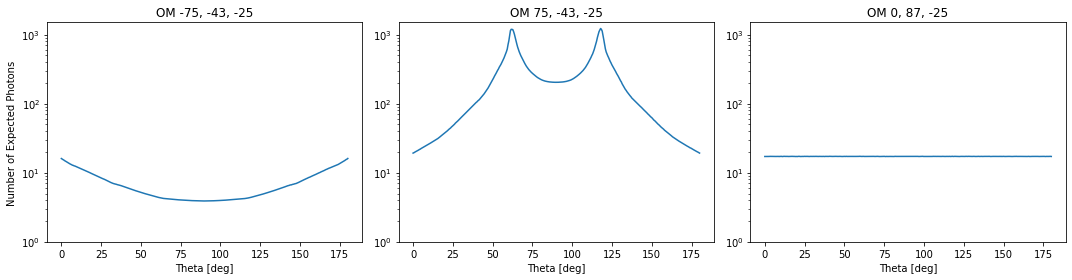

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
thetas = np.radians(np.linspace(0, 180, 360))
for i, ax in enumerate(axs):
    mod_coords = det.module_coords[i]
    t_geo = np.linalg.norm(event_data["pos"] - mod_coords) / (c_medium_f(700) / 1E9)
    times = jnp.linspace(t_geo-10, t_geo+300, 310)

    key, subkey = random.split(key)
    keys = random.split(subkey, len(thetas))
    
    

    shape_lh, counts_lh, n_ph_expec = eval_for_mod_split_vmap_theta(
        event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], thetas,
        event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
        times, mod_coords, det.module_noise_rates[i], keys
    )  

    colors = sns.color_palette("crest", len(thetas))

    ax.plot(np.degrees(thetas), n_ph_expec)
    ax.set_yscale("log")
    ax.set_ylim(1, 1500)
    ax.set_xlabel("Theta [deg]")
    ax.set_title(f"OM {mod_coords[0]:.0f}, {mod_coords[1]:.0f}, {mod_coords[2]:.0f}")

axs[0].set_ylabel("Number of Expected Photons")
plt.tight_layout()
plt.savefig("figures/cascade_photons_demo.png", dpi=180)

DeviceArray([ 57, 886, 157], dtype=int32)

TypeError: make_realistic_cascade_source() missing 1 required positional argument: 'key'

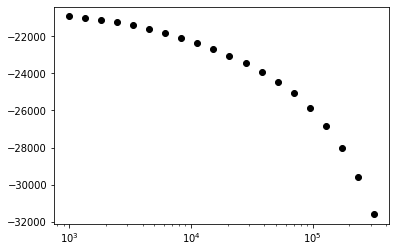

<Figure size 432x288 with 0 Axes>

In [26]:

nmeas = jnp.asarray(ak.count(event, axis=1))

def eval_energy(energy):
    sources = make_realistic_cascade_source(event_data["pos"], event_data["time"], event_dir, energy, 11, resolution=0.5, key=random.PRNGKey(0))
    return evlh(
        pad_event(event),
        jnp.asarray(ak.count(event, axis=1)),
        det.module_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9,
        det.module_noise_rates
    ).sum()

eval_energy_j = jax.jit(eval_energy)

def eval_x(x):

    pos = jnp.asarray([event_data["pos"][0], x, event_data["pos"][2]])
    sources = make_realistic_cascade_source(pos, event_data["time"], event_dir, event_data["energy"], 11, resolution=0.5)
    return evlh(
        pad_event(event),
        jnp.asarray(ak.count(event, axis=1)),
        det.module_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9,
        det.module_noise_rates
    ).sum()

eval_x_j = jax.jit(eval_x)


energies = jnp.logspace(3, 5.5, 20)
for e in energies:
    plt.plot(e, eval_energy_j(e), "ok")
plt.semilogx()

plt.figure()
xs = np.linspace(-0.5, 0.5, 20)

for x in xs:
    plt.plot(x, eval_x_j(x), "ok")



In [22]:
matrices = []
energies = np.logspace(3, 5, 5)
crs = []
spacings = np.linspace(75, 200, 10)

key = random.PRNGKey(0)
for e in energies:
    for spacing in spacings:
        det = make_triang(spacing, 1, dist_z, dark_noise_rate, rng)
        for i in range(40):
            key, k1, k2 = random.split(key, 3)
            event, _ = generate_cascade(
                det, event_data["pos"], event_data["t0"], event_dir, energy=e, particle_id=event_data["pid"], pprop_func=gen_ph,
                seed=k1, 
                converter_func=make_realistic_cascade_source,
                #converter_func=make_pointlike_cascade_source,
                pprop_extras={"c_medium": c_medium_f(700) / 1E9},
                #converter_extras={"resolution": 0.5}
            )
            if ak.count(event) == 0:
                continue
            evpd = pad_event(event)

            jacsum = 0
            for j in range(evpd.shape[0]):
                if jnp.all(~jnp.isfinite(evpd[j])):
                    continue
                res = jnp.stack(eval_jacobian(event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], event_data["theta"], event_data["phi"], event_data["t0"], 
                                    np.log10(e),
                                    evpd[j],
                                    det.module_coords[j],
                                    det.module_noise_rates[j],
                                    k2))
                jacsum += res
            matrices.append(np.asarray(jacsum[:, np.newaxis] * jacsum[np.newaxis, :]))

        cr = np.average(np.stack(matrices), axis=0)
        crs.append([e, spacing] + list(np.sqrt(np.diag(np.linalg.inv(cr)))))



/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650:

In [23]:
df = pd.DataFrame(crs, columns=["energy_sim", "spacing", "x", "y", "z", "theta", "phi", "t", "logE" ])
df["theta_deg"] = np.degrees(df["theta"])
df["phi_deg"] = np.degrees(df["phi"])
df.set_index("energy_sim", inplace=True)

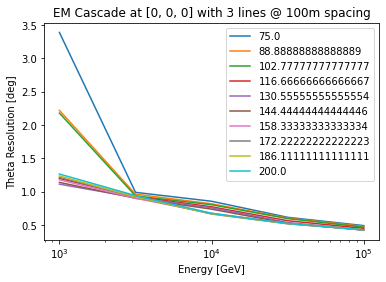

In [24]:
for groupn, group in df.groupby("spacing"):
    plt.plot(group.index, group.theta_deg, label=groupn)
    plt.semilogx()
    plt.xlabel("Energy [GeV]")
    plt.ylabel("Theta Resolution [deg]")
    plt.title("EM Cascade at [0, 0, 0] with 3 lines @ 100m spacing")
plt.legend()

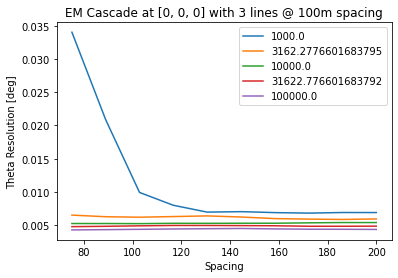

In [30]:
for groupn, group in df.groupby(level=0):
    plt.plot(group.spacing, group.logE, label=groupn)
    #plt.semilogx()
    plt.xlabel("Spacing")
    plt.ylabel("Theta Resolution [deg]")
    plt.title("EM Cascade at [0, 0, 0] with 3 lines @ 100m spacing")
plt.legend()
#plt.semilogy()

In [7]:
det.module_noise_rates * 6000

array([1.18187338, 0.42906911, 0.48745309])

In [10]:
ak.count(event, axis=1)

<Array [0, 3, 62] type='3 * int64'>

/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


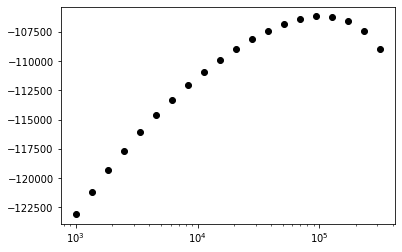

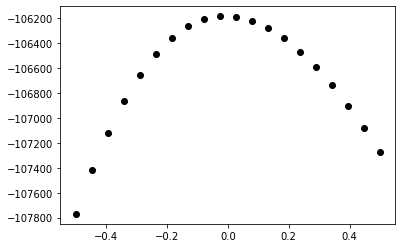

In [7]:
eval_energy_j(e)

DeviceArray(-inf, dtype=float32)

In [5]:
"""
sources = make_realistic_cascade_source(event_data["pos"], event_data["t0"], event_dir, event_data["energy"], 11)
split_ev = [
    gen_ph(det.module_coords, det.module_efficiencies, [sources[i]], seed=1, c_medium=c_medium_f(700) / 1E9)
    for i in range(len(sources))
]
spl_sum = ak.concatenate([ev for ev in split_ev if ak.count(ev) > 0], axis=1)
"""


'\nsources = make_realistic_cascade_source(event_data["pos"], event_data["t0"], event_dir, event_data["energy"], 11)\nsplit_ev = [\n    gen_ph(det.module_coords, det.module_efficiencies, [sources[i]], seed=1, c_medium=c_medium_f(700) / 1E9)\n    for i in range(len(sources))\n]\nspl_sum = ak.concatenate([ev for ev in split_ev if ak.count(ev) > 0], axis=1)\n'

In [6]:
prop = proposal_setup()

In [7]:
track_event, track_record = generate_realistic_track(
    det, event_data["pos"], event_dir, track_len=300, t0=event_data["t0"], energy=event_data["energy"], pprop_func=gen_ph,
    seed=1, 
    pprop_extras={"c_medium": c_medium_f(700) / 1E9},
    propagator = prop
)


In [18]:
det = make_triang(175, 1, dist_z, dark_noise_rate, rng)
event_data = {"t0": 0., "theta": np.radians(45), "phi": np.radians(60), "pos": np.asarray([0, 0, -25.]), "energy": 1E5, "pid": 11}
event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])
event2, record2 = generate_cascade(
    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=gen_ph,
    seed=1, 
    converter_func=make_realistic_cascade_source,
    pprop_extras={"c_medium": c_medium_f(700) / 1E9},
    converter_extras={"resolution": 0.5}
)

event3, record3 = generate_cascade(
    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=gen_ph,
    seed=2, 
    converter_func=make_realistic_cascade_source,
    pprop_extras={"c_medium": c_medium_f(700) / 1E9},
    converter_extras={"resolution": 0.5}
)




/opt/conda/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3650: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


In [19]:
ak.count(event2, axis=1)

<Array [0, 3, 62] type='3 * int64'>

In [20]:
event2,_ = simulate_noise(det, event2)

In [21]:
det.module_coords

array([[-87.5       , -50.51814855, -25.        ],
       [ 87.5       , -50.51814855, -25.        ],
       [  0.        , 101.03629711, -25.        ]])

In [22]:
np.linalg.norm(det.module_coords, axis=1)

array([104.08329997, 104.08329997, 104.08329997])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


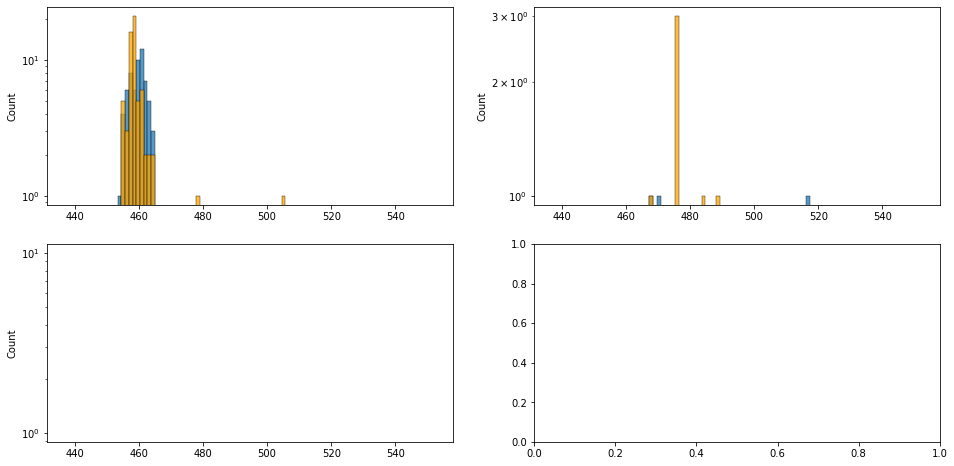

In [23]:
ixso = ak.argsort(ak.count(event2, axis=1))[::-1]

fig, axs = plt.subplots(2, 2, figsize=(16, 8))



for ix, ax in zip(ixso, axs.ravel()):

    mod_coords = det.module_coords[ix]

    t_geo = np.linalg.norm(event_data["pos"] - mod_coords) / (c_medium_f(700) / 1E9)
    binning = np.linspace(t_geo-15, t_geo + 100, 100)

    times = event2[ix]
    if len(times) > 0:
        sns.histplot(np.asarray(times), bins=binning, ax=ax)

    times = event3[ix]
    if len(times) > 0:
        sns.histplot(np.asarray(times), bins=binning, ax=ax, color="orange")
    ax.set_yscale("log")

    """
    
    times = spl_sum[ix]
    sns.histplot(np.asarray(times), bins=binning, ax=ax, color="blue")
    for spl in split_ev:
        if ak.count(spl) > 0:
            times = spl[ix]
            sns.histplot(np.asarray(times), bins=binning, ax=ax, color="blue")
    """


In [12]:
energies = np.logspace(3, 5, 10)
fishers = []
key = random.PRNGKey(0)
for energy in energies:
    for pos in [np.asarray([0, 0, 0.]), np.asarray([0, 50., 0.])]:
        key, subkey = random.split(key)
        event_data = {"t0": 0., "theta": np.radians(30), "phi": np.radians(25), "pos": np.asarray([0, 0, 0.]), "energy": energy, "pid": 11}
        fisher = calc_fisher_info_cascades(det, event_data, subkey, make_realistic_cascade_source, gen_ph, evlh, c_medium_f(700)/1E9, n_ev=5)
        fishers.append((fisher, energy, pos))

In [ ]:
cr_data = []
for (fi, energy, pos) in fishers:
    cr = np.sqrt(jnp.diag(jnp.linalg.inv(fi)))
    cr_data.append([energy, tuple(pos)]  + list(cr))
   
    
df = pd.DataFrame(cr_data, columns=["energy_sim", "pos_sim", "x", "y", "z", "theta", "phi", "t", "log10(energy/GeV)" ])
df["theta_deg"] = np.degrees(df["theta"])
df["phi_deg"] = np.degrees(df["phi"])
df.set_index("energy_sim", inplace=True)

In [ ]:
for groupn, group in df.groupby("pos_sim"):
    plt.plot(group.index, group.theta_deg, label=groupn)
    plt.loglog()
    plt.xlabel("Energy [GeV]")
    plt.ylabel("Theta Resolution [deg]")
    plt.title("EM Cascade at [0, 0, 0] with 3 lines @ 100m spacing")
plt.legend()

In [ ]:
for groupn, group in df.groupby("pos_sim"):
    plt.plot(group.index, group.phi_deg, label=groupn)
    plt.loglog()
    plt.xlabel("Energy [GeV]")
    plt.ylabel("Theta Resolution [deg]")
    plt.title("EM Cascade at [0, 0, 0] with 3 lines @ 100m spacing")
plt.legend()

In [ ]:
def eval_lh_time(time, energy):
    sources = make_pointlike_cascade_source(event_data["pos"], time, event_dir, energy, 11)
    return eval_likelihood(event, det.module_coords, sources, c_medium_f(700) / 1E9)

jax.grad(eval_lh_time)(11., 1E7)

In [ ]:
def eval_lh_energy(energy):
    sources = make_pointlike_cascade_source(event_data["pos"], event_data["t0"], event_dir, energy, 11)
    return eval_likelihood(event, det.module_coords, sources, c_medium_f(700) / 1E9)

jax.grad(eval_lh_time)(11., 1E7)
energies = jnp.logspace(1, 7, 50)
lhs = jax.vmap((eval_lh_energy))(energies)
plt.plot(energies, lhs)
plt.semilogx()

In [ ]:
source = PhotonSource(jnp.asarray([0., 10., -2.]), 1E9, 0, jnp.asarray([0., 1, 0]))
source2 = PhotonSource(jnp.asarray([0., 299., -50.]), 1E13, 300, jnp.asarray([0., 1, 0]))
source3 = PhotonSource(jnp.asarray([0., -10., 3.]), 9E7, 300, jnp.asarray([0., 1, 0]))
#det = Detector(make_hex_grid(4, 100, 20, 50))

sources = [source, source2, source3]

det = Detector(make_line(0, 0, 2, 50, np.random.RandomState(0), 1E3, 0))

event = gen_ph(det.module_coords, det.module_efficiencies, [source, source2, source3], c_medium_f(700)/1E9, seed=2)

eval_likelihood(event, det.module_coords, sources, c_medium_f(700) / 1E9)




In [ ]:
source = PhotonSource(jnp.asarray([0., 10., -2.]), 1E9, 0, jnp.asarray([0., 1, 0]))
source2 = PhotonSource(jnp.asarray([0., 299., -50.]), 1E13, 300, jnp.asarray([1., 0, 0]))
source3 = PhotonSource(jnp.asarray([0., -10., 3.]), 9E7, 300, jnp.asarray([0., 1, 0]))
#det = Detector(make_hex_grid(4, 100, 20, 50))

sources = [source, source2, source3]
eval_likelihood(event, det.module_coords, sources, c_medium_f(700) / 1E9)

In [ ]:
c_medium = 0.299792458 / medium["n_ph"]
ixs = jnp.sum(event_binned, axis=1)
#binning = np.linspace(-20, 100, 120)

def add_tts(times, res):
    return times + np.random.normal(0, scale=res, size=len(times))


for res in [2]:
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    colors = sns.color_palette("colorblind")
    for ix, ax in zip(ixs, axs.ravel()):

        det_dist = np.linalg.norm(event_data["pos"] - det.module_coords[ix])

        times = np.asarray(event[ix])
        tgeo = event_data["t0"] + det_dist / c_medium
        
        amps, steps = event_binned[0][ix]
        amps = amps.detach().cpu()
        steps = steps.detach().cpu()

        #sns.histplot(add_tts(event3[ix], res)-tgeo, bins=binning, color=colors[0], ax=ax, alpha=0.7, element="step", fill=False, label="Pointlike")
        ax.step(steps, np.append(amps, amps[-1]), where="post")
        sns.histplot(add_tts(times, res), bins=steps, ax=ax, alpha=0.7, element="step", color=colors[1], fill=False, label="EM")
        
       
        
        #sns.histplot(add_tts(event2[ix], res)-tgeo, bins=binning, ax=ax, alpha=0.7, element="step", color=colors[2], fill=False, label="Hadr")

        ax.set_yscale("log")
        ax.set_title(f"Module Pos: { det.module_coords[ix]}")
        ax.set_xlim(steps[0] - 10, steps[0] + 150)
    axs[0][0].legend()

In [ ]:
test_energy = 5E5
em_counts_func, em_long_func, em_angles_func = fennel_instance.em_yields(energy=test_energy, particle=11, mean=True, function=True)
had_counts_func, had_long_func, had_em_func, had_angles_func = fennel_instance.hadron_yields(energy=test_energy, particle=211, mean=True, function=True)

zgrid = np.linspace(0, 15*100, 1000)

#em_counts_val = em_counts_func(test_energy, wavelengths, 11, mean=True)
em_long_val = em_long_func(test_energy, zgrid, fennel_instance._particles[11])
hadr_long_val = had_long_func(test_energy, zgrid, fennel_instance._particles[211])
#em_angles_val = em_angles_func(angle_grid, 1.33, fennel_instance._particles[11])





int_grid = np.linspace(0, 20, 40)
integrals_em = []
integrals_had = []
integrand_em = lambda z: em_long_func(event_data["energy"], z, particle=fennel_instance._particles[11])
integrand_had = lambda z: had_long_func(event_data["energy"], z, particle=fennel_instance._particles[211])

norm_em = scipy.integrate.quad(integrand_em, 0, np.infty)[0]
norm_had = scipy.integrate.quad(integrand_had, 0, np.infty)[0]
wavelengths = np.linspace(350, 500, 100)
nph_em = np.trapz(em_counts_func(test_energy, wavelengths, particle=11).ravel(), wavelengths)
nph_had = np.trapz(had_counts_func(test_energy, wavelengths, particle=211).ravel(), wavelengths)


event_dir = sph_to_cart_np(event_data["theta"], event_data["phi"])

ph_sources_em = []
ph_sources_had = []
for i in range(len(int_grid)-1):
    
    inte_em = scipy.integrate.quad(integrand_em, int_grid[i]*100, int_grid[i+1]*100)
    integrals_em.append(inte_em[0]/norm_em*nph_em)
    
    inte_had = scipy.integrate.quad(integrand_had, int_grid[i]*100, int_grid[i+1]*100)
    integrals_had.append(inte_had[0]/norm_had*nph_had)
    
    dist_along = 0.5*(int_grid[i] + int_grid[i+1])
    src_pos = dist_along * event_dir + event_data["pos"]
    ph_sources_em.append(
        PhotonSource(src_pos, inte_em[0]/norm_em*nph_em, event_data["t0"] + dist_along / 0.299792458, event_dir)
    )
    
    ph_sources_had.append(
        PhotonSource(src_pos, inte_had[0]/norm_had*nph_had, event_data["t0"] + dist_along / 0.299792458, event_dir)
    )

half = 0.5*(int_grid[1:] + int_grid[:-1])
    
plt.plot(half, integrals_em)
plt.plot(half, integrals_had)

In [ ]:
event = gen_ph(det.module_coords, det.module_efficiencies, ph_sources_em)
event2 = gen_ph(det.module_coords, det.module_efficiencies, ph_sources_had)

event3 = gen_ph(det.module_coords, det.module_efficiencies,
                [PhotonSource(event_data["pos"], nph, event_data["t0"], event_dir)])


In [ ]:
det_dist

In [ ]:
ixs = ak.argsort(ak.count(event, axis=1), ascending=False)
binning = np.linspace(-20, 100, 120)

def add_tts(times, res):
    return times + np.random.normal(0, scale=res, size=len(times))


for res in [0, 3,]:
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    colors = sns.color_palette("colorblind")
    for ix, ax in zip(ixs, axs.ravel()):

        det_dist = np.linalg.norm(event_data["pos"] - det.module_coords[ix])

        times = np.asarray(event[ix])
        tgeo = event_data["t0"] + det_dist / c_medium

        #sns.histplot(add_tts(event3[ix], res)-tgeo, bins=binning, color=colors[0], ax=ax, alpha=0.7, element="step", fill=False, label="Pointlike")
        sns.histplot(add_tts(times, res)-tgeo, bins=binning, ax=ax, alpha=0.7, element="step", color=colors[1], fill=False, label="EM")
        #sns.histplot(add_tts(event2[ix], res)-tgeo, bins=binning, ax=ax, alpha=0.7, element="step", color=colors[2], fill=False, label="Hadr")

        ax.set_yscale("log")
        ax.set_title(f"Module Pos: { det.module_coords[ix]}")
    axs[0][0].legend()

In [ ]:
event_data["dir"]

In [ ]:

plt.plot(wavelengths, em_counts_func(test_energy, wavelengths, particle=11))
 / (5.3 * 250 * 1E2 * test_energy  )

In [ ]:
config['advanced']['wavelengths']

In [ ]:
em_counts_val / np.diff(wavelengths)[0]

In [ ]:
event_data = {"t0":, 0, "theta": np.radians(10), "phi": np.radians(20), "pos": np.asarray([0, 0, 0.]), "energy": 1E5}
event, record = generate_cascade(
    det, pos, t0_gen, cdir, n_photons=amp_gen, pprop_func=gen_ph
)